In [16]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

import rioxarray
import matplotlib.pyplot as plt
import pyproj

import math
from xrspatial import slope
from xrspatial import hillshade
from xrspatial import aspect
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.colors import Elevation

import holoviews as hv
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
from scipy.spatial import distance

import fsspec
from datetime import datetime as dt

from geoviews import opts
from geoviews import tile_sources as gvts
from datashader.colors import viridis
import datashader
from holoviews.operation.datashader import datashade, shade, dynspread, spread, rasterize
from holoviews.streams import Selection1D, Params
import panel as pn
import param as pm
import warnings
import holoviews.operation.datashader as hd
warnings.filterwarnings("ignore")
import requests
from io import StringIO

# View stations

In [3]:

def get_station_metadata(state):
    url = f"https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultipleStationReport/daily/start_of_period/state=%22{state}%22AND%20outServiceDate=%222100-01-01%22%7Cname/0,0/name,stationId,state.name,state.code,elevation,latitude,longitude,WTEQ::value?fitToScreen=false"
    #f""""https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultipleStationReport/daily/end_of_period/state=%22CO%22%20AND%20county=%22Adams%22,%22Alamosa%22,%22Arapahoe%22,%22Archuleta%22,%22Baca%22,%22Bent%22,%22Boulder%22,%22Broomfield%22,%22Chaffee%22,%22Cheyenne%22,%22Clear%20Creek%22,%22Conejos%22,%22Costilla%22,%22Crowley%22,%22Custer%22,%22Delta%22,%22Denver%22,%22Dolores%22,%22Douglas%22,%22Eagle%22,%22El%20Paso%22,%22Elbert%22,%22Fremont%22,%22Garfield%22,%22Gilpin%22,%22Grand%22,%22Gunnison%22,%22Hinsdale%22,%22Huerfano%22,%22Jackson%22,%22Jefferson%22,%22Kiowa%22,%22Kit%20Carson%22,%22La%20Plata%22,%22Lake%22,%22Larimer%22,%22Las%20Animas%22,%22Lincoln%22,%22Logan%22,%22Mesa%22,%22Mineral%22,%22Moffat%22,%22Montezuma%22,%22Montrose%22,%22Morgan%22,%22Otero%22,%22Ouray%22,%22Park%22,%22Phillips%22,%22Pitkin%22,%22Prowers%22,%22Pueblo%22,%22Rio%20Blanco%22,%22Rio%20Grande%22,%22Routt%22,%22Saguache%22,%22San%20Juan%22,%22San%20Miguel%22,%22Sedgwick%22,%22Summit%22,%22Teller%22,%22Washington%22,%22Weld%22,%22Yuma%22%20AND%20outServiceDate=%222100-01-01%22%7Cname/0,0/name,stationId,state.name,state.code,elevation,latitude,longitude"""#f"""https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/state=%22{state}%22%20AND%20network=%22SNTLT%22,%22SNTL%22%20AND%20element=%22SNWD%22%20AND%20outServiceDate=%222100-01-01%22%7Cname~0/0,0/name,elevation,stationId,latitude,longitude"""
    response = requests.get(url)
    if response.status_code == 200:
        content = response.text
        num_comment_lines = sum(1 for line in content.split('\n') if line.startswith('#'))
        station_df = pd.read_csv(StringIO(content), skiprows=num_comment_lines)
    else:
        station_df = None
        raise Exception(f"No station data for state: {state}")
    return station_df


In [4]:
states = ["CO", "WY", "MT", "ID", "UT", "CA", "OR", "WA"]
dfs = []

for state in states:
    print(state)
    state_df = get_station_metadata(state)
    state_df['state'] = state
    dfs.append(state_df)

sno_df = pd.concat(dfs, ignore_index=True)

CO
WY
MT
ID
UT
CA
OR
WA


In [5]:
sno_df.columns = [col.lower().replace(' ','_') for col in sno_df.columns]
sno_df = sno_df[['station_name','station_id','state_name','state_code','elevation_(ft)','latitude','longitude']]
sno_df.head()

,station_name,station_id,state_name,state_code,elevation_(ft),latitude,longitude
0,Apishapa,303,COLORADO,CO,10027,37.33067,-105.06766
1,Arapaho Ridge,1030,COLORADO,CO,10976,40.35098,-106.38141
2,Bear Lake,322,COLORADO,CO,9522,40.31176,-105.64670
3,Bear River,1061,COLORADO,CO,9112,40.06152,-107.00948
4,Beartown,327,COLORADO,CO,11600,37.71433,-107.51240


In [6]:
sno_gdf = gpd.GeoDataFrame(sno_df,
                           geometry=gpd.points_from_xy(sno_df['longitude'], sno_df['latitude']))
sno_gdf['station_id_s'] = sno_df['station_id'].apply(lambda x:str(x))

In [38]:
sno_gdf.iloc[0].longitude

-105.06766

In [ ]:
import geopandas as gpd
from geopy.distance import geodesic

# Assuming your GeoPandas DataFrame is named 'gdf'
# and you have a specific location in latitude and longitude
target_location = (target_latitude, target_longitude)

# Function to calculate distance between two points
def calculate_distance(row):
    point = (row['latitude'], row['longitude'])
    return geodesic(target_location, point).km

# Calculate distances and add a new column to the DataFrame
gdf['distance_to_target'] = gdf.apply(calculate_distance, axis=1)

# Sort the DataFrame by the calculated distances
sorted_gdf = gdf.sort_values(by='distance_to_target')


In [36]:
sno_gdf.hvplot.points( color='red', tiles='OSM',geo=True, hover_cols=['station_name','elevation_(ft)','station_id_s'],width=800,height=800)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (station_name,elevation_(ft),station_id_s)

In [35]:
hvplot.extension('bokeh')

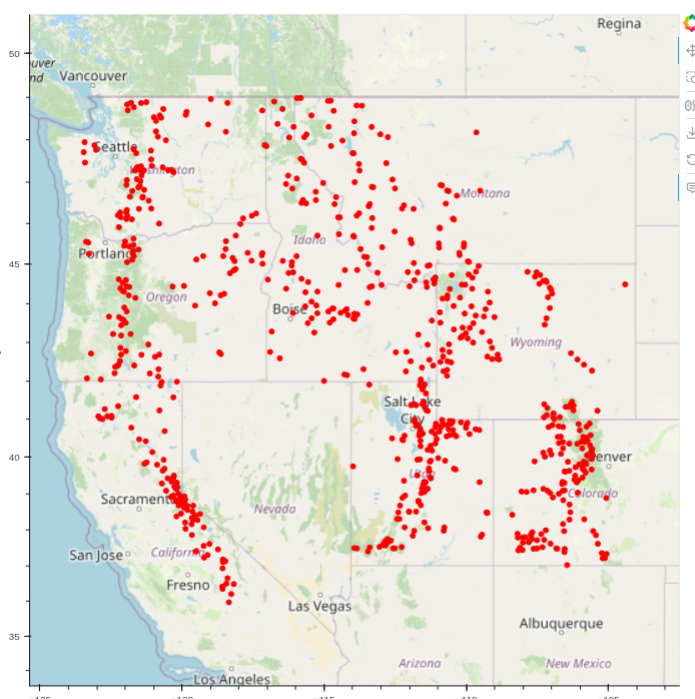

# Station Monthly Data

In [233]:
from datetime import datetime

def get_station_monthly(id, state, start_date = '1970-01-01', end_date = datetime.now().strftime('%Y-%m-%d')):
    url=f'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/monthly/end_of_period/{id}:{state}:SNTL%7Cid=%22%22%7Cname/1980-01-01,2024-01-13/name,stationId,WTEQ::value,SNWD::value,PRCP::value,PRCP::median_1991,PRCP::pctOfMedian_1991,PRCP::average_1991,PRCP::qcFlag,PRCP::qaFlag,TAVG::value,RHUMV::value,SNRR::value,SNDN::value,elevation'

    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        num_comment_lines = sum(1 for line in content.split('\n') if line.startswith('#'))
        df = pd.read_csv(StringIO(content), skiprows=num_comment_lines)
        df['month'] = df['Date'].apply(lambda x:x.split()[0])
        df['year'] = df['Date'].apply(lambda x:x.split()[1])
        cols = [col.lower().replace(' ','_').replace('end_of_month_values','') for col in df.columns]
        df.columns = cols
    else:
        print(response)
        raise Exception('Invalid reponse')
        df = None
    return df

def get_station_daily(id, state, start_date = '1980-01-01', end_date = datetime.now().strftime('%Y-%m-%d')):
    url=f'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/start_of_period/{id}:{state}:SNTL%7Cid=%22%22%7Cname/1980-01-01,2024-01-13/name,stationId,WTEQ::value,SNWD::value,PRCP::value,PRCP::median_1991,PRCP::pctOfMedian_1991,PRCP::average_1991,PRCP::qcFlag,PRCP::qaFlag,TAVG::value,RHUMV::value,SNRR::value,SNDN::value,elevation'

    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        num_comment_lines = sum(1 for line in content.split('\n') if line.startswith('#'))
        df = pd.read_csv(StringIO(content), skiprows=num_comment_lines)
        df['month'] = df['Date'].apply(lambda x:x.split('-')[1])
        df['year'] = df['Date'].apply(lambda x:x.split('-')[0])
        df['day'] = df['Date'].apply(lambda x:x.split('-')[2])
        cols = [col.lower().replace(' ','_').replace('(','').replace(')','') for col in df.columns]
        df.columns = cols
    else:
        print(response)
        raise Exception('Invalid reponse')
        df = None
    return df

In [234]:
df = get_station_daily(id=679,state='WA')
df['incr_swe_precip'] = df['snow_rain_ratio_unitless'] / 100 * df['precipitation_increment_in']
df[df.incr_swe_precip.notnull()].head()
monthly = df.groupby(['year','month']).agg({'air_temperature_average_degf':'mean','incr_swe_precip':'sum'}).reset_index()
monthly

In [236]:
df['incr_swe_precip'] = df['snow_rain_ratio_unitless'] / 100 * df['precipitation_increment_in']
df[df.incr_swe_precip.notnull()].head()
monthly = df.groupby(['year','month']).agg({'air_temperature_average_degf':'mean','incr_swe_precip':'sum'}).reset_index()
monthly

,date,station_name,station_id,snow_water_equivalent_in_start_of_day_values,snow_depth_in_start_of_day_values,precipitation_increment_in,median_precipitation_increment_1991-2020_in,precipitation_increment_%_of_median_1991-2020,average_precipitation_increment_1991-2020_in,precipitation_increment_qc_flag,precipitation_increment_qa_flag,air_temperature_average_degf,relative_humidity_average_pct,snow_rain_ratio_unitless,snow_density_pct_start_of_day_values,elevation_ft,month,year,day,incr_swe_precip
11,1980-10-12,Paradise,679,0.0,NaN,1.3,NaN,NaN,NaN,E,U,NaN,NaN,0.0,NaN,5130,10,1980,12,0.0
12,1980-10-13,Paradise,679,0.0,NaN,0.2,NaN,NaN,NaN,E,U,NaN,NaN,100.0,NaN,5130,10,1980,13,0.2
13,1980-10-14,Paradise,679,0.2,NaN,0.1,NaN,NaN,NaN,V,U,NaN,NaN,300.0,NaN,5130,10,1980,14,0.3
15,1980-10-16,Paradise,679,0.6,NaN,0.1,NaN,NaN,NaN,V,U,NaN,NaN,0.0,NaN,5130,10,1980,16,0.0
23,1980-10-24,Paradise,679,0.8,NaN,0.4,NaN,NaN,NaN,V,U,NaN,NaN,0.0,NaN,5130,10,1980,24,0.0


In [237]:
monthly = df.groupby(['year','month']).agg({'air_temperature_average_degf':'mean','incr_swe_precip':'sum'}).reset_index()
monthly

,year,month,air_temperature_average_degf,incr_swe_precip
0,1980,10,NaN,0.500
1,1980,11,NaN,8.318
2,1980,12,NaN,8.003
3,1981,01,NaN,2.800
4,1981,02,NaN,11.319
...,...,...,...,...
515,2023,09,48.283333,0.000
516,2023,10,43.851613,1.100
517,2023,11,36.050000,6.108
518,2023,12,36.156667,11.103


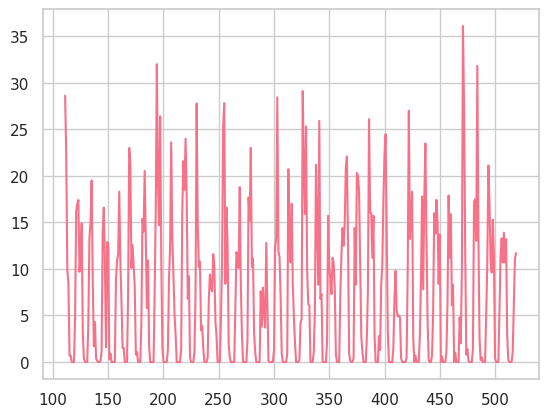

In [240]:
monthly = monthly[monthly.year.apply(lambda x:int(x)>=1990)]
fig,ax=plt.subplots()
ax.plot(monthly.incr_swe_precip)

# ESNO Historic

In [184]:
next_month = {"ASO":11,"SON":12,"OND":1,"NDJ":2,"DJF":3,"JFM":4}

In [185]:
esno_df = pd.read_csv('esno_historic.csv')
esno_df = esno_df.drop(columns = ['Unnamed: 0'])
esno_df.head()
esno_df = pd.melt(esno_df, id_vars=['ENSO Type', 'Season'], var_name='three_month_range', value_name='oni_value')
esno_df = esno_df.sort_values('Season')
esno_df['month'] = esno_df['three_month_range'].apply(lambda x:next_month.get(x))
esno_df = esno_df.rename(columns = {"oni_value": "oni_value_L3M",'Season':'winter_season'})
esno_df.head()

,ENSO Type,winter_season,three_month_range,oni_value_L3M,month
0,ML,1970-1971,JJA,-0.6,NaN
162,ML,1970-1971,SON,-0.7,12.0
594,ML,1970-1971,MJJ,-0.7,NaN
216,ML,1970-1971,OND,-0.9,1.0
54,ML,1970-1971,JAS,-0.8,NaN


In [171]:
next_month = {"ASO":"Nov","SON":"Dec","OND":"Jan","NDJ":"Feb","DJF":"Mar","JFM":"Apr"}

# Locations

In [53]:
import geopandas as gpd
from geopy.distance import geodesic
locations = {'seattle': (47.6061,-122.3328),
            'aspen': (39.191,-106.817),
            'whitefish': (48.411,-114.338)}

def calculate_distance(row, loc):
    point = (row['latitude'], row['longitude'])
    return geodesic(target_location, (row['latitude'], row['longitude'])).km

def sort_by_distance(gdf, loc):
    gdf['distance'] = gdf.apply(
        lambda x: geodesic(loc, (x['latitude'], x['longitude'])).km, axis=1)
    gdf = gdf.sort_values('distance', ascending = True)
    return gdf


In [147]:
import calendar
def get_local_winter_monthly_hist(state:str,
                                  station_ids:list,
                                  winter_months = [11,12,1,2,3,4]):

    df = pd.DataFrame()
    for sid in station_ids:
        df = pd.concat([df, get_station_monthly(id = sid, state = state)])
    df['month'] = df['month'].apply(lambda x: list(calendar.month_abbr).index(x))
    winter_df = df[df.month.apply(lambda x : x in winter_months)]
    mask = winter_df['month'].apply(lambda x : x >= 11)
    winter_df.loc[mask, 'winter_season'] = winter_df.loc[mask, 'year'].apply(lambda x:f'{x}-{int(x)+1}')
    winter_df.loc[~mask, 'winter_season'] = winter_df.loc[~mask, 'year'].apply(lambda x:f'{int(x)-1}-{x}')
    return winter_df

## Paul - Seattle

In [221]:
wa_sno = sno_gdf[sno_gdf.longitude.apply(lambda x: x>=locations['seattle'][1])]
wa_sno = wa_sno[wa_sno['elevation_(ft)'].apply(lambda x:x>=4500)].iloc[0:10]
wa_sno.head()

,station_name,station_id,state_name,state_code,elevation_(ft),latitude,longitude,geometry,station_id_s,distance
719,Sawmill Ridge,1068,WASHINGTON,WA,4640,47.15992,-121.42172,POINT (-121.42172 47.15992),1068,84.814422
679,Corral Pass,418,WASHINGTON,WA,5800,47.01872,-121.46464,POINT (-121.46464 47.01872),418,92.591965
699,Morse Lake,642,WASHINGTON,WA,5410,46.90585,-121.48270,POINT (-121.48270 46.90585),642,100.999319
707,Paradise,679,WASHINGTON,WA,5130,46.78265,-121.74765,POINT (-121.74765 46.78265),679,101.719732
678,Cayuse Pass,1085,WASHINGTON,WA,5240,46.86954,-121.53430,POINT (-121.53430 46.86954),1085,101.787949


In [128]:
wa_sno = sno_gdf[sno_gdf.longitude.apply(lambda x: x>=locations['seattle'][1])]
wa_sno = wa_sno[wa_sno['elevation_(ft)'].apply(lambda x:x>=4500)].iloc[0:10]
wa_sno.hvplot.points( color='red', tiles='OSM',geo=True, hover_cols=['station_name','elevation_(ft)','station_id_s'],width=400,height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (station_name,elevation_(ft),station_id_s)

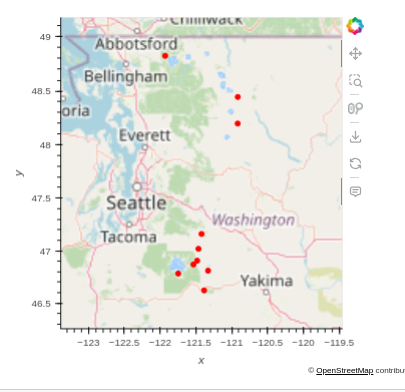

In [148]:
wa_hist = get_local_winter_monthly_hist(state = 'WA', station_ids = wa_sno.iloc[0:6].station_id_s.to_list())

In [158]:
len(wa_hist[wa_hist['median_precipitation_increment_(1991-2020)_(in)'].notnull()].station_name.unique())

6

In [186]:
wa_hist = wa_hist.merge(esno_df,on=['winter_season','month'],how='left')
wa_hist.head()

,date,station_name,station_id,snow_water_equivalent_(in)_,snow_depth_(in)_,precipitation_increment_(in),median_precipitation_increment_(1991-2020)_(in),precipitation_increment_%_of_median_(1991-2020),average_precipitation_increment_(1991-2020)_(in),precipitation_increment_qc_flag,...,relative_humidity_average_(pct),snow_rain_ratio_(unitless),snow_density_(pct)_,elevation_(ft),month,year,winter_season,ENSO Type,three_month_range,oni_value_L3M
0,Jan 1980,Sawmill Ridge,1068,NaN,NaN,NaN,9.4,NaN,9.5,NaN,...,NaN,NaN,NaN,4640,1,1980,1979-1980,WE,OND,0.5
1,Feb 1980,Sawmill Ridge,1068,NaN,NaN,NaN,8.6,NaN,8.5,NaN,...,NaN,NaN,NaN,4640,2,1980,1979-1980,WE,NDJ,0.6
2,Mar 1980,Sawmill Ridge,1068,NaN,NaN,NaN,7.2,NaN,8.6,NaN,...,NaN,NaN,NaN,4640,3,1980,1979-1980,WE,DJF,0.6
3,Apr 1980,Sawmill Ridge,1068,NaN,NaN,NaN,6.4,NaN,6.1,NaN,...,NaN,NaN,NaN,4640,4,1980,1979-1980,WE,JFM,0.5
4,Nov 1980,Sawmill Ridge,1068,NaN,NaN,NaN,10.0,NaN,9.3,NaN,...,NaN,NaN,NaN,4640,11,1980,1980-1981,,ASO,-0.1


#### ONI index

In [241]:
df = get_station_daily(id=679,state='WA')
df['incr_swe_precip'] = df['snow_rain_ratio_unitless'] / 100 * df['precipitation_increment_in']
df[df.incr_swe_precip.notnull()].head()
monthly = df.groupby(['year','month']).agg({'air_temperature_average_degf':'mean','incr_swe_precip':'sum'}).reset_index()
monthly

,year,month,air_temperature_average_degf,incr_swe_precip
0,1980,10,NaN,0.500
1,1980,11,NaN,8.318
2,1980,12,NaN,8.003
3,1981,01,NaN,2.800
4,1981,02,NaN,11.319
...,...,...,...,...
515,2023,09,48.283333,0.000
516,2023,10,43.851613,1.100
517,2023,11,36.050000,6.108
518,2023,12,36.156667,11.103


In [243]:
monthly['year'] = monthly['year'].astype(int)
monthly['month'] = monthly['month'].astype(int)
mask = monthly['month'].apply(lambda x : x >= 11)
monthly.loc[mask, 'winter_season'] = monthly.loc[mask, 'year'].apply(lambda x:f'{x}-{int(x)+1}')
monthly.loc[~mask, 'winter_season'] = monthly.loc[~mask, 'year'].apply(lambda x:f'{int(x)-1}-{x}')

In [244]:
monthly = monthly.merge(esno_df,on=['winter_season','month'],how='left')
monthly

,year,month,air_temperature_average_degf,incr_swe_precip,winter_season,ENSO Type,three_month_range,oni_value_L3M
0,1980,10,NaN,0.500,1979-1980,NaN,NaN,NaN
1,1980,11,NaN,8.318,1980-1981,,ASO,-0.1
2,1980,12,NaN,8.003,1980-1981,,SON,0.0
3,1981,1,NaN,2.800,1980-1981,,OND,0.1
4,1981,2,NaN,11.319,1980-1981,,NDJ,0.0
...,...,...,...,...,...,...,...,...
515,2023,9,48.283333,0.000,2022-2023,NaN,NaN,NaN
516,2023,10,43.851613,1.100,2022-2023,NaN,NaN,NaN
517,2023,11,36.050000,6.108,2023-2024,ME,ASO,1.6
518,2023,12,36.156667,11.103,2023-2024,ME,SON,1.8


In [249]:
monthly = monthly[monthly.month.apply(lambda x:x in [12,1,2,3])]

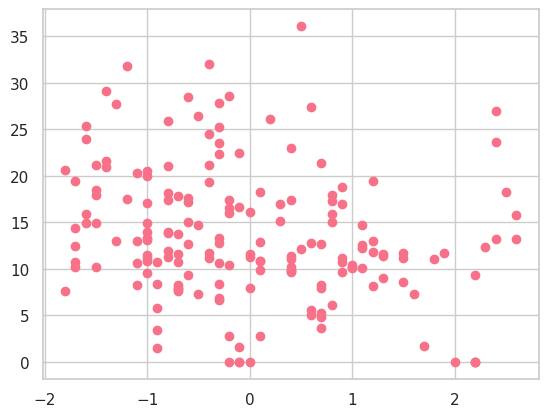

In [250]:
fig,ax=plt.subplots()
ax.scatter(monthly.oni_value_L3M,monthly.incr_swe_precip)

In [200]:
wa_hist.columns = [col.replace('(','').replace(')','') for col in wa_hist.columns]
march = wa_hist[wa_hist.month==3]
march = march[march.station_name=='Paradise']
march = march[march.snow_water_equivalent_in_.notnull()]
np.corrcoef(march['snow_water_equivalent_in_'],march['oni_value_L3M'])

array([[ 1.        , -0.35966582],
       [-0.35966582,  1.        ]])

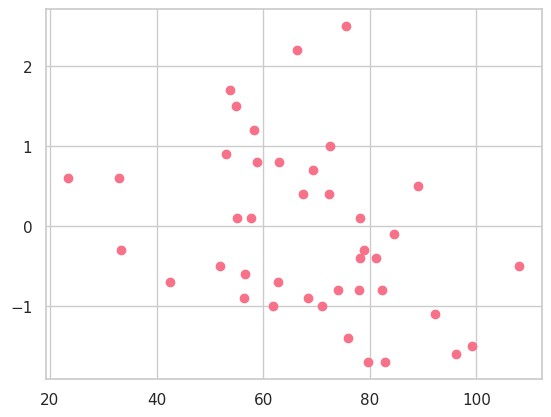

In [203]:
fig,ax=plt.subplots()
ax.scatter(march['snow_water_equivalent_in_'],march.oni_value_L3M)

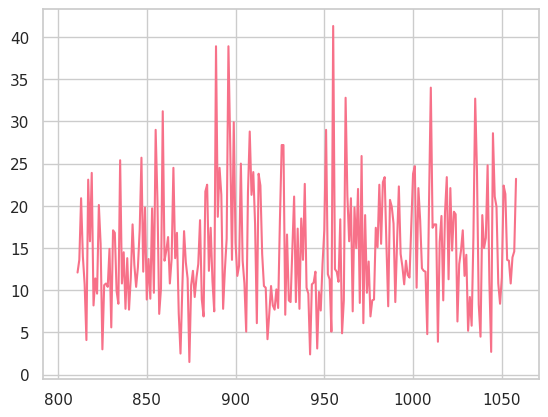

In [210]:
paradise = wa_hist[wa_hist.station_name=='Paradise'].iloc[9::]
paradise = paradise.sort_values(['year','month'])
fig,ax=plt.subplots()
ax.plot(paradise['precipitation_increment_in'])

In [215]:
paradise[paradise.snow_rain_ratio_unitless.notnull()]

,date,station_name,station_id,snow_water_equivalent_in_,snow_depth_in_,precipitation_increment_in,median_precipitation_increment_1991-2020_in,precipitation_increment_%_of_median_1991-2020,average_precipitation_increment_1991-2020_in,precipitation_increment_qc_flag,...,relative_humidity_average_pct,snow_rain_ratio_unitless,snow_density_pct_,elevation_ft,month,year,winter_season,ENSO Type,three_month_range,oni_value_L3M
804,Apr 1981,Paradise,679,38.9,NaN,15.2,7.8,195.0,8.8,E,...,NaN,64.0,NaN,5130,4,1981,1980-1981,,JFM,-0.5
817,Nov 1983,Paradise,679,23.5,NaN,23.1,17.2,134.0,18.1,E,...,NaN,102.0,NaN,5130,11,1983,1983-1984,WL,ASO,-0.5
818,Dec 1983,Paradise,679,37.5,NaN,15.8,15.0,105.0,17.9,E,...,NaN,89.0,NaN,5130,12,1983,1983-1984,WL,SON,-0.8
819,Jan 1984,Paradise,679,48.7,NaN,23.9,17.6,136.0,18.2,E,...,NaN,47.0,NaN,5130,1,1984,1983-1984,WL,OND,-1.0
820,Feb 1984,Paradise,679,43.1,NaN,8.2,13.6,60.0,13.8,E,...,NaN,18.0,NaN,5130,2,1984,1983-1984,WL,NDJ,-0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,Feb 2023,Paradise,679,52.0,132.0,13.5,13.6,99.0,13.8,E,...,NaN,105.0,39.4,5130,2,2023,2022-2023,WL,NDJ,-0.8
1055,Mar 2023,Paradise,679,62.8,148.0,10.8,11.0,98.0,14.0,E,...,NaN,101.0,42.4,5130,3,2023,2022-2023,WL,DJF,-0.7
1056,Apr 2023,Paradise,679,73.0,134.0,13.9,7.8,178.0,8.8,E,...,NaN,105.0,54.5,5130,4,2023,2022-2023,WL,JFM,-0.4
1057,Nov 2023,Paradise,679,7.1,18.0,14.6,17.2,85.0,18.1,V,...,NaN,50.0,39.4,5130,11,2023,2023-2024,ME,ASO,1.6


In [217]:
paradise = paradise[paradise.snow_water_equivalent_in_.notnull()]
np.corrcoef(paradise.snow_water_equivalent_in_,paradise.oni_value_L3M)

array([[ 1.        , -0.18797967],
       [-0.18797967,  1.        ]])

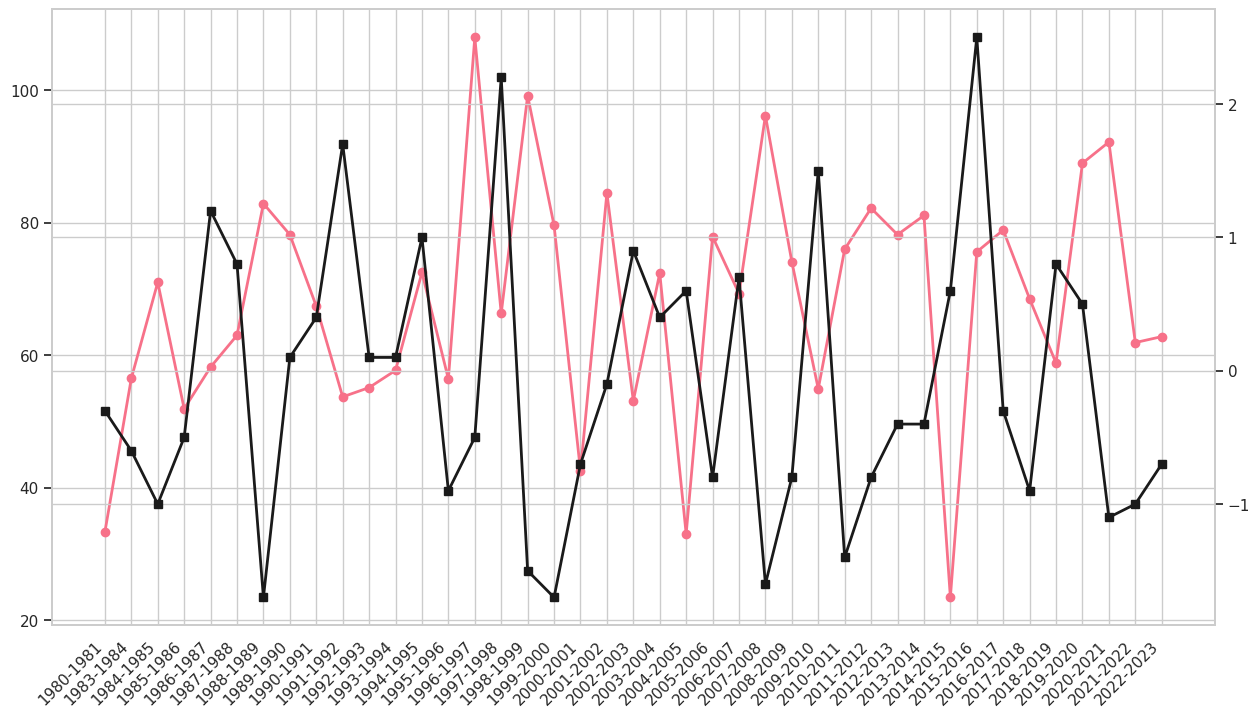

In [208]:
march = march.sort_values(by=['winter_season'])
march = march[march.winter_season.apply(lambda x:x!=current_season)]
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(march['winter_season'], march['snow_water_equivalent_in_'],'o-',linewidth=2)#, label=station)
plt.xticks(rotation=45, ha='right');  # Rotate x-axis ticks for better visibility

ax2 = ax.twinx()

ax2.plot(march['winter_season'], march['oni_value_L3M'], 's-', linewidth=2, label=station + ' - ONI',color='k')


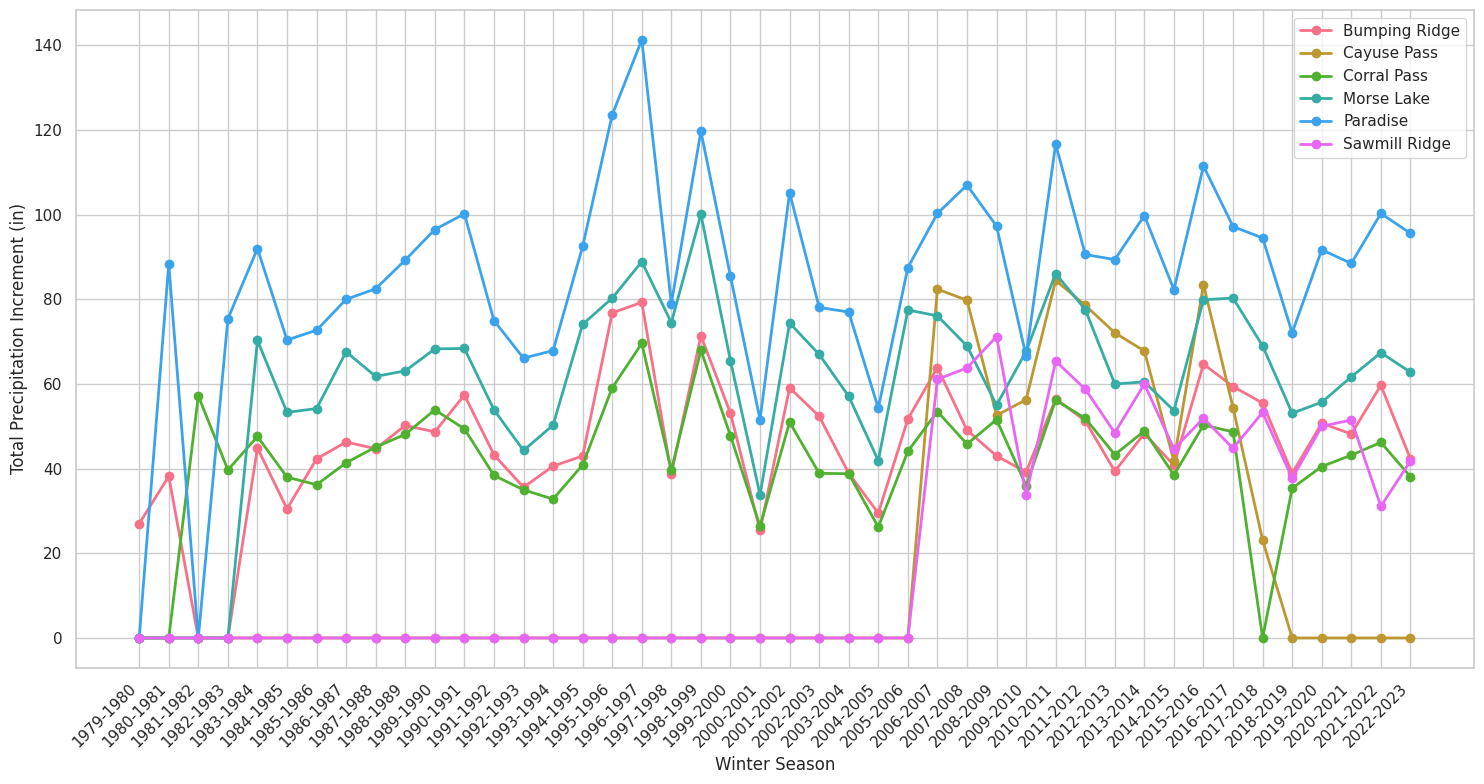

In [187]:
annual = wa_hist.groupby(['station_name','winter_season']).agg({'precipitation_increment_(in)':'sum','air_temperature_average_(degf)':'mean','oni_value_L3M':'mean'}).reset_index()
current_season = '2023-2024'
annual = annual.sort_values(by=['winter_season'])
annual = annual[annual.winter_season.apply(lambda x:x!=current_season)]
fig, ax = plt.subplots(figsize = (15, 8))
for station, group in annual.groupby('station_name'):
    plt.plot(group['winter_season'], group['precipitation_increment_(in)'],'o-',linewidth=2, label=station)

plt.xlabel('Winter Season')
plt.ylabel('Total Precipitation Increment (in)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis ticks for better visibility
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [195]:
paradise.describe()

,precipitation_increment_(in),air_temperature_average_(degf),oni_value_L3M
count,35.000000,35.000000,35.000000
mean,91.191429,31.070667,-0.097143
std,19.044165,1.744811,1.013403
min,51.600000,27.850000,-1.566667
25%,78.550000,29.616667,-0.850000
50%,91.700000,31.283333,-0.200000
75%,100.250000,31.941667,0.591667
max,141.300000,35.533333,2.400000


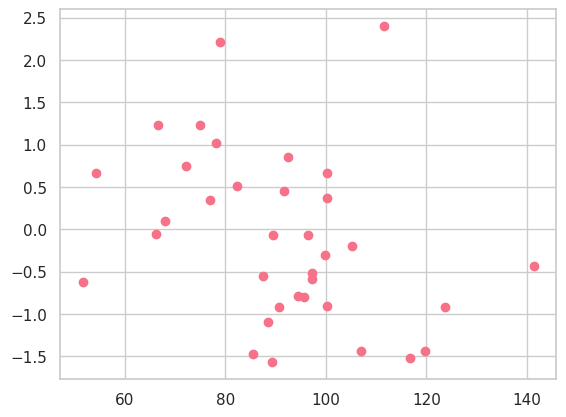

In [196]:
paradise = annual[annual.station_name=='Paradise'].iloc[9::]

np.corrcoef(paradise['precipitation_increment_(in)'],paradise.oni_value_L3M)
fig,ax=plt.subplots()
ax.scatter(paradise['precipitation_increment_(in)'],paradise.oni_value_L3M)

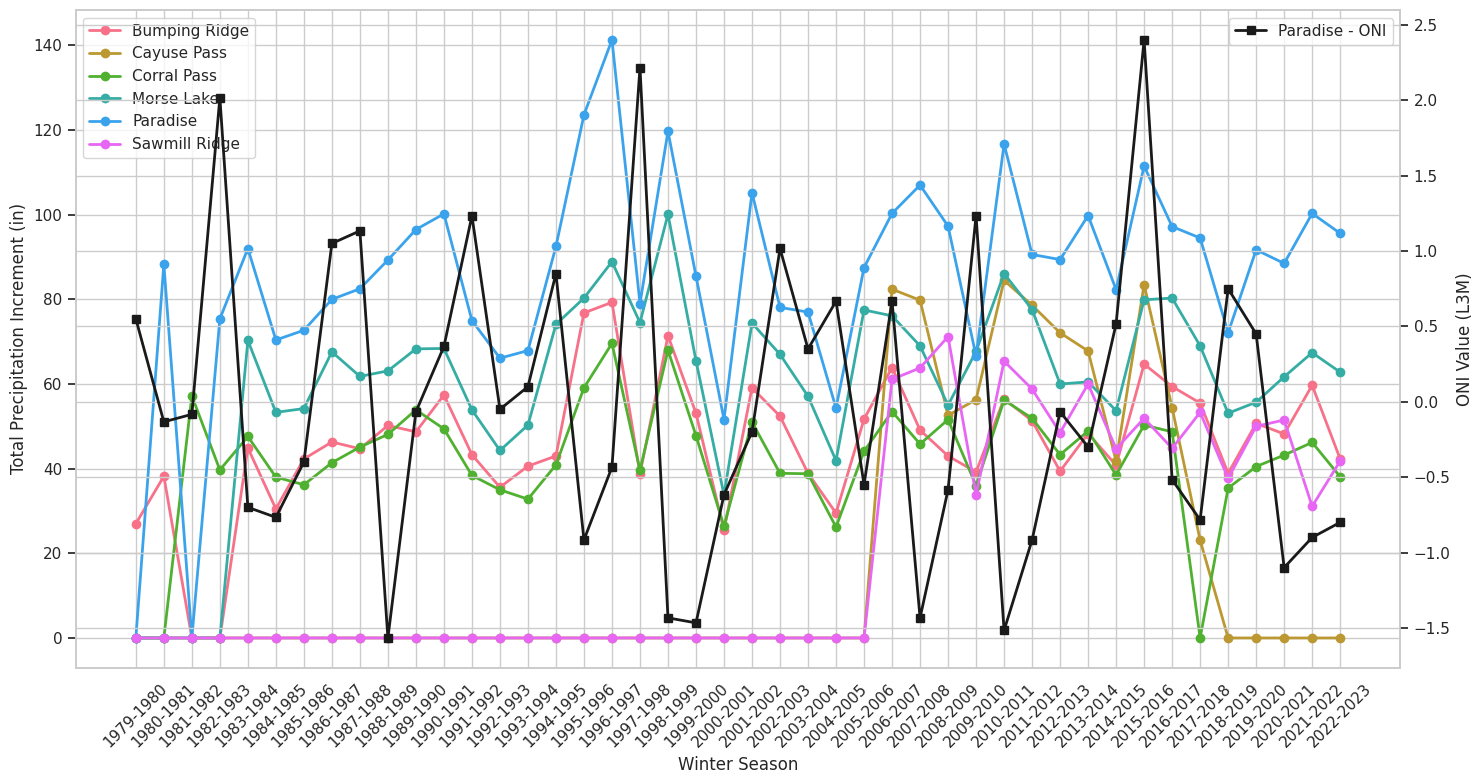

In [191]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 8))

for station, group in annual.groupby('station_name'):
    ax1.plot(group['winter_season'], group['precipitation_increment_(in)'], 'o-', linewidth=2, label=station)

ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Total Precipitation Increment (in)')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks for better visibility
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

for station, group in annual[annual.station_name=='Paradise'].groupby('station_name'):
    ax2.plot(group['winter_season'], group['oni_value_L3M'], 's-', linewidth=2, label=station + ' - ONI',color='k')

ax2.set_ylabel('ONI Value (L3M)')
ax2.legend(loc='upper right')

plt.tight_layout()

plt.show()

In [192]:
group

,station_name,winter_season,precipitation_increment_(in),air_temperature_average_(degf),oni_value_L3M
180,Paradise,1979-1980,0.0,NaN,0.550000
181,Paradise,1980-1981,88.3,NaN,-0.133333
182,Paradise,1981-1982,0.0,NaN,-0.083333
183,Paradise,1982-1983,75.4,NaN,2.016667
184,Paradise,1983-1984,92.0,NaN,-0.700000
185,Paradise,1984-1985,70.4,NaN,-0.766667
186,Paradise,1985-1986,72.7,NaN,-0.400000
187,Paradise,1986-1987,80.0,NaN,1.050000
188,Paradise,1987-1988,82.5,NaN,1.133333
189,Paradise,1988-1989,89.3,32.000000,-1.566667


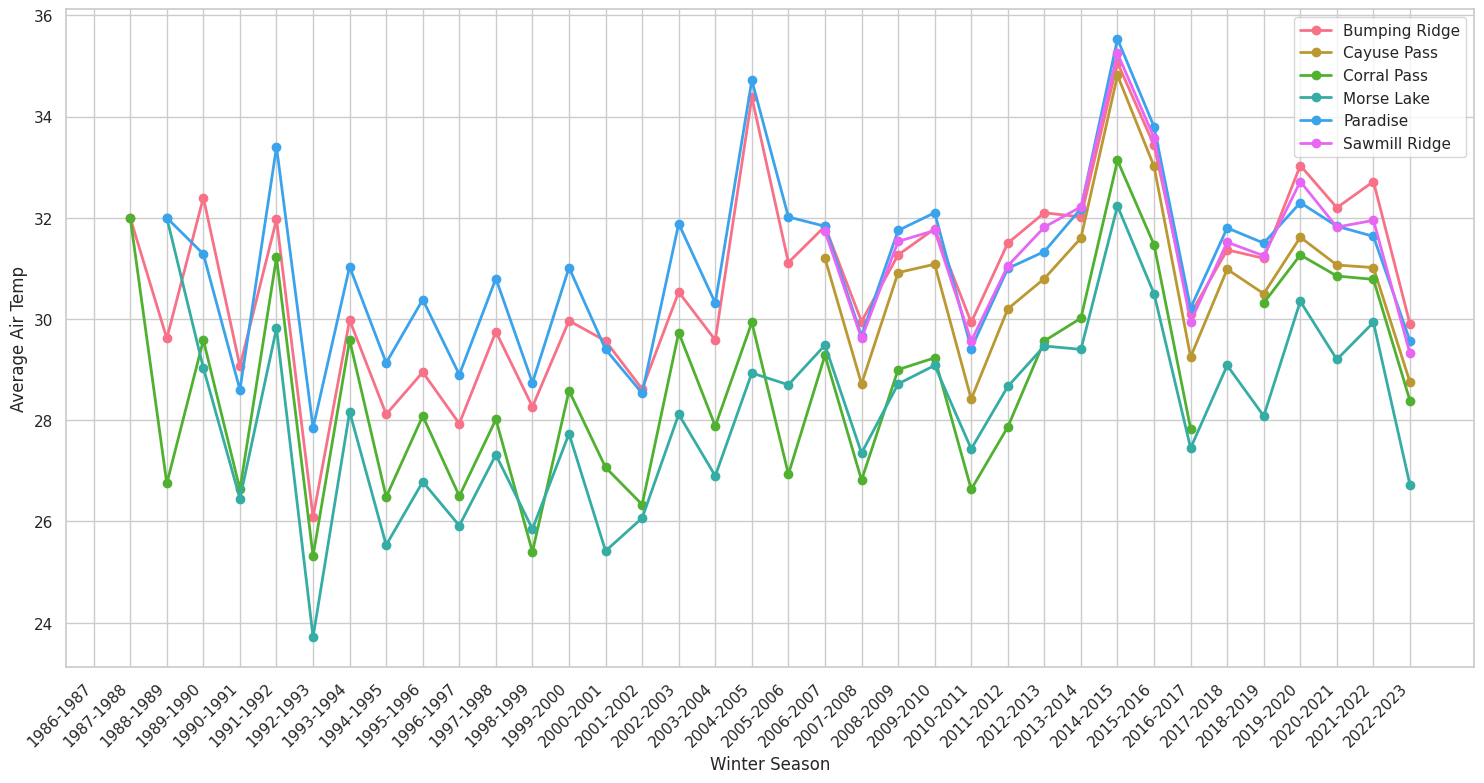

In [161]:
fig, ax = plt.subplots(figsize = (15, 8))
for station, group in annual.groupby('station_name'):
    plt.plot(group['winter_season'], group['air_temperature_average_(degf)'],'o-',linewidth=2, label=station)

plt.xlabel('Winter Season')
plt.ylabel('Average Air Temp')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis ticks for better visibility
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [130]:
wa_hist_winter = wa_hist[wa_hist.month.apply(lambda x : x in [11,12,1,2,3,4])]
len(wa_hist_winter)

2650

In [131]:
wa_hist_winter['snow_density'] = wa_hist_winter['snow_water_equivalent_(in)_'] / wa_hist_winter['snow_depth_(in)_']

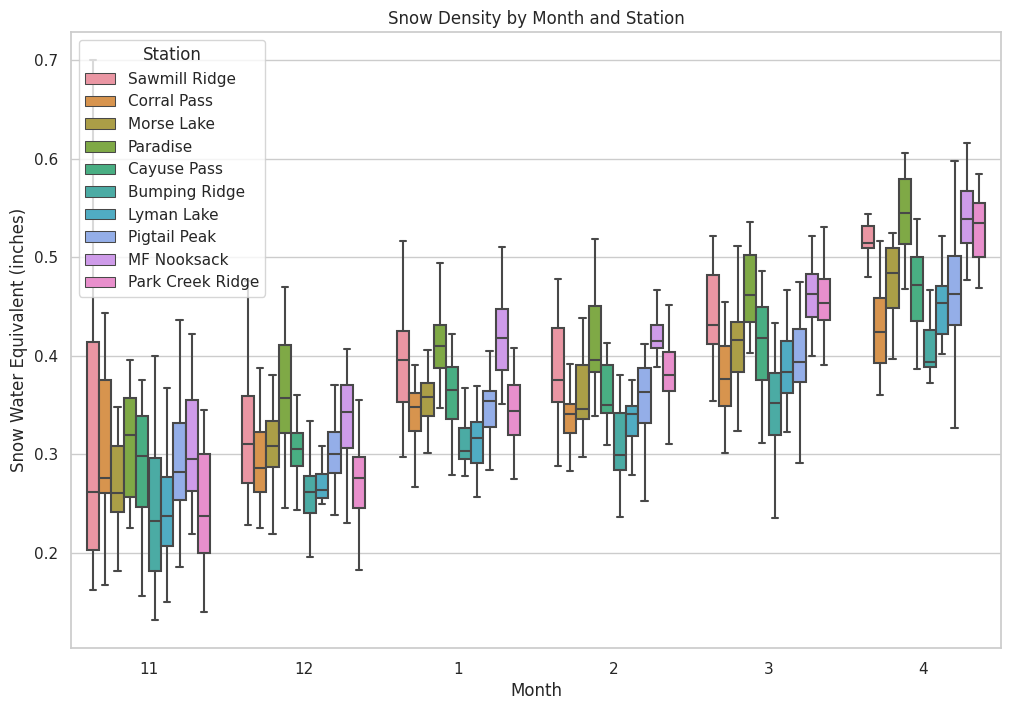

In [134]:
import seaborn as sns

month_order = [11, 12, 1, 2, 3, 4]
plt.figure(figsize=(12, 8))
sns.boxplot(x='month', y='snow_density', hue='station_name',
            data=wa_hist_winter, order=month_order, showfliers=False)  # showfliers=False removes outliers
plt.title('Snow Density by Month and Station')
plt.xlabel('Month')
plt.ylabel('Snow Water Equivalent (inches)')
plt.legend(title='Station', loc='upper left')
plt.show()

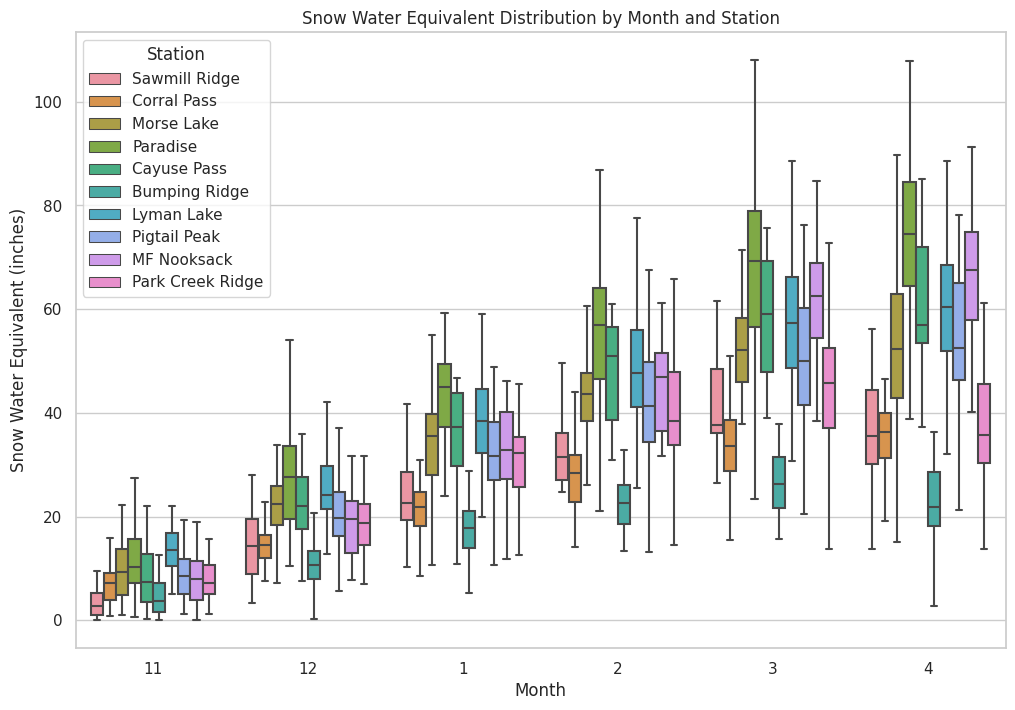

In [133]:
import seaborn as sns

month_order = [11, 12, 1, 2, 3, 4]
plt.figure(figsize=(12, 8))
sns.boxplot(x='month', y='snow_water_equivalent_(in)_', hue='station_name',
            data=wa_hist_winter, order=month_order, showfliers=False)  # showfliers=False removes outliers
plt.title('Snow Water Equivalent Distribution by Month and Station')
plt.xlabel('Month')
plt.ylabel('Snow Water Equivalent (inches)')
plt.legend(title='Station', loc='upper left')
plt.show()

AttributeError: 'Axes' object has no attribute 'xlabel'

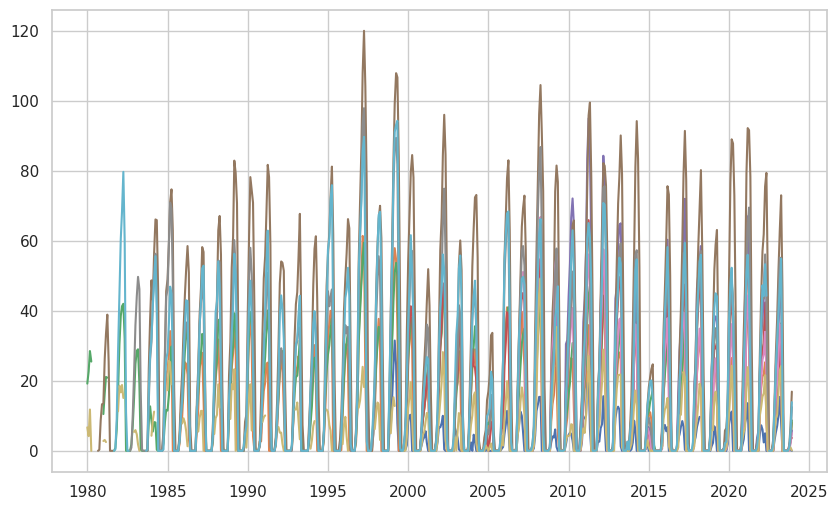

In [111]:
%matplotlib inline
wa_hist['date'] = pd.to_datetime(wa_hist['date'])

# Sort the DataFrame by date
wa_hist = wa_hist.sort_values(by='date')
fig, ax = plt.subplots(figsize = (10,6))

# Iterate through unique station_names
for station_name in wa_hist['station_name'].unique():
    # Filter the DataFrame for the current station_name
    station_data = wa_hist[wa_hist['station_name'] == station_name]
    
    # Plotting the data for the current station_name
    ax.plot(station_data['date'], station_data['snow_water_equivalent_(in)_'], label=station_name)

# Adding labels and legend
#ax.xlabel('Date')
#ax.ylabel('Snow Water Equivalent (in)')
ax.title('Snow Water Equivalent vs Time for Each Station')
ax.legend()
ax.grid(True)


In [106]:
wa_hist_grouped = wa_hist.groupby(['station_name', 'date'])['snow_water_equivalent_(in)_'].mean().reset_index()


In [108]:
# Sort the DataFrame by date
wa_hist_grouped.sort_values(by='date', inplace=True)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x="date", y="snow_water_equivalent_(in)_", hue="station_name", data=wa_hist_grouped, ci=None)

plt.xlabel("Date")
plt.ylabel("Snow Water Equivalent (in)")
plt.title("Snow Water Equivalent vs Time")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [94]:
wa_hist.columns

Index(['date', 'station_name', 'station_id', 'snow_water_equivalent_(in)_',
       'snow_depth_(in)_', 'precipitation_increment_(in)',
       'median_precipitation_increment_(1991-2020)_(in)',
       'precipitation_increment_%_of_median_(1991-2020)',
       'average_precipitation_increment_(1991-2020)_(in)',
       'precipitation_increment_qc_flag', 'precipitation_increment_qa_flag',
       'air_temperature_average_(degf)', 'relative_humidity_average_(pct)',
       'snow_rain_ratio_(unitless)', 'snow_density_(pct)_', 'elevation_(ft)',
       'month', 'year'],
      dtype='object')

## Stephen - Aspen 

In [57]:
sno_gdf = sort_by_distance(sno_gdf, locations['aspen'])
sno_gdf.head()

,station_name,station_id,state_name,state_code,elevation_(ft),latitude,longitude,geometry,station_id_s,distance
15,Chapman Tunnel,1101,COLORADO,CO,10100,39.26210,-106.62944,POINT (-106.62944 39.26210),1101,18.016888
68,Nast Lake,658,COLORADO,CO,8731,39.29695,-106.60786,POINT (-106.60786 39.29695),658,21.548291
42,Independence Pass,542,COLORADO,CO,10598,39.07543,-106.61154,POINT (-106.61154 39.07543),542,21.913626
47,Kiln,556,COLORADO,CO,9624,39.31720,-106.61501,POINT (-106.61501 39.31720),556,22.366877
101,Upper Taylor,1141,COLORADO,CO,10717,38.99071,-106.74504,POINT (-106.74504 38.99071),1141,23.090740


In [59]:
sno_gdf.iloc[0:5].hvplot.points( color='red', tiles='OSM',geo=True, hover_cols=['station_name','elevation_(ft)','station_id_s'],width=400,height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (station_name,elevation_(ft),station_id_s)

## Christine -- Whitefish

In [64]:
sno_gdf = sort_by_distance(sno_gdf, locations['whitefish'])
sno_gdf.head()

,station_name,station_id,state_name,state_code,elevation_(ft),latitude,longitude,geometry,station_id_s,distance
228,Emery Creek,469,MONTANA,MT,4350,48.43412,-113.93725,POINT (-113.93725 48.43412),469,29.772249
271,Stryker Basin,1311,MONTANA,MT,6194,48.68005,-114.66365,POINT (-114.66365 48.68005),1311,38.382966
234,Hand Creek,510,MONTANA,MT,5035,48.30754,-114.84075,POINT (-114.84075 48.30754),510,38.992374
252,Noisy Basin,664,MONTANA,MT,6040,48.15678,-113.94637,POINT (-113.94637 48.15678),664,40.544385
209,Blacktail Mtn,1144,MONTANA,MT,5650,47.98288,-114.35430,POINT (-114.35430 47.98288),1144,47.619860


In [63]:
sno_gdf.iloc[0:5].hvplot.points( color='red', tiles='OSM',geo=True, hover_cols=['station_name','elevation_(ft)','station_id_s'],width=400,height=400)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (station_name,elevation_(ft),station_id_s)

# Get station historic data

In [109]:
url='https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/monthly/end_of_period/679:WA:SNTL%7Cid=%22%22%7Cname/1980-01-01,2024-01-13/name,stationId,WTEQ::value,SNWD::value,PRCP::value,PRCP::median_1991,PRCP::pctOfMedian_1991,PRCP::average_1991,PRCP::qcFlag,PRCP::qaFlag,TAVG::value,RHUMV::value,elevation'

response = requests.get(url)

if response.status_code == 200:
    content = response.text

num_comment_lines = sum(1 for line in content.split('\n') if line.startswith('#'))
num_comment_lines
df = pd.read_csv(StringIO(content), skiprows=num_comment_lines)



In [110]:
df.head()

,Date,Station Name,Station Id,Snow Water Equivalent (in) End of Month Values,Snow Depth (in) End of Month Values,Precipitation Increment (in),Median Precipitation Increment (1991-2020) (in),Precipitation Increment % of Median (1991-2020),Average Precipitation Increment (1991-2020) (in),Precipitation Increment QC Flag,Precipitation Increment QA Flag,Air Temperature Average (degF),Relative Humidity Average (pct),Elevation (ft),Latitude,Longitude
0,Jan 1980,Paradise,679,NaN,NaN,NaN,17.6,NaN,18.2,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765
1,Feb 1980,Paradise,679,NaN,NaN,NaN,13.6,NaN,13.8,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765
2,Mar 1980,Paradise,679,NaN,NaN,NaN,11.0,NaN,14.0,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765
3,Apr 1980,Paradise,679,NaN,NaN,NaN,7.8,NaN,8.8,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765
4,May 1980,Paradise,679,NaN,NaN,NaN,5.6,NaN,5.5,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765


In [111]:
df['month'] = df['Date'].apply(lambda x:x.split()[0])
df['year'] = df['Date'].apply(lambda x:x.split()[1])
cols = df.columns
cols = [col.lower().replace(' ','_') for col in cols]
df.columns = cols
df.head()

,date,station_name,station_id,snow_water_equivalent_(in)_end_of_month_values,snow_depth_(in)_end_of_month_values,precipitation_increment_(in),median_precipitation_increment_(1991-2020)_(in),precipitation_increment_%_of_median_(1991-2020),average_precipitation_increment_(1991-2020)_(in),precipitation_increment_qc_flag,precipitation_increment_qa_flag,air_temperature_average_(degf),relative_humidity_average_(pct),elevation_(ft),latitude,longitude,month,year
0,Jan 1980,Paradise,679,NaN,NaN,NaN,17.6,NaN,18.2,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765,Jan,1980
1,Feb 1980,Paradise,679,NaN,NaN,NaN,13.6,NaN,13.8,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765,Feb,1980
2,Mar 1980,Paradise,679,NaN,NaN,NaN,11.0,NaN,14.0,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765,Mar,1980
3,Apr 1980,Paradise,679,NaN,NaN,NaN,7.8,NaN,8.8,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765,Apr,1980
4,May 1980,Paradise,679,NaN,NaN,NaN,5.6,NaN,5.5,NaN,NaN,NaN,NaN,5130,46.78265,-121.74765,May,1980


In [113]:
nino = [1988,1992,2024,1983,1998,2016]
nina = [1996,2012,2021,2022,1989,1999,2000,2008,2011]
df['esno'] = df['year'].apply(lambda x:'nina' if int(x) in nina else 'nino' if int(x) in nino else 'neutral')
df['nino'] = df['year'].apply(lambda x:int(x) in nino)


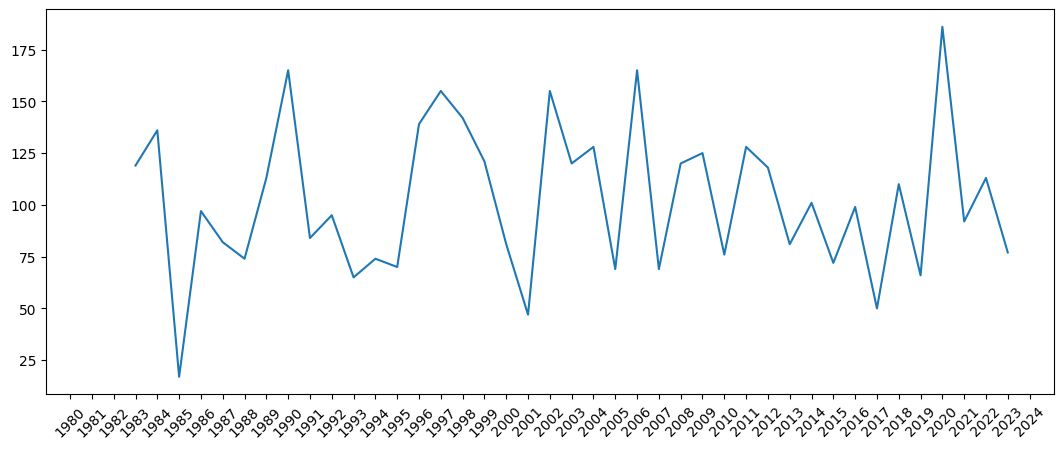

In [114]:
fig,ax=plt.subplots(figsize = (13,5))
plt.xticks(rotation=45)
subdf = df[df.month=='Jan']
ax.plot(subdf.year,subdf['precipitation_increment_%_of_median_(1991-2020)'])

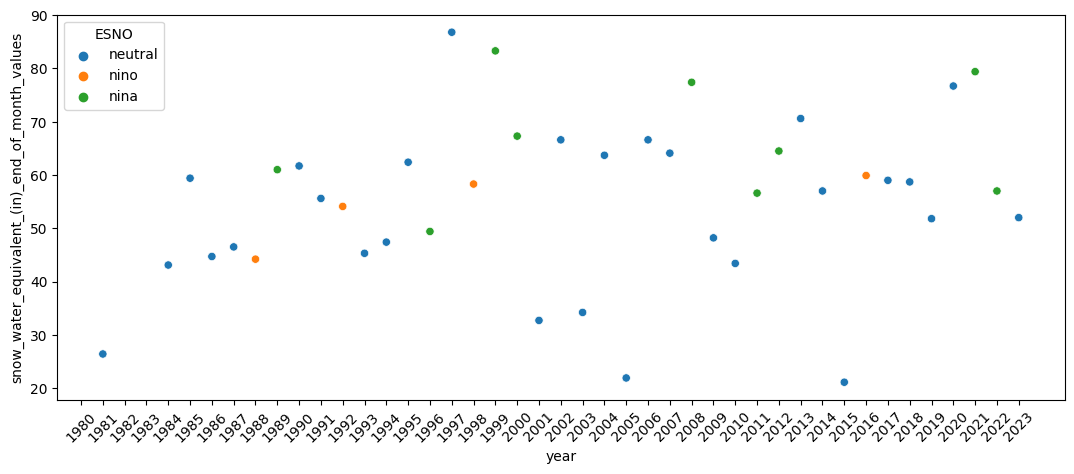

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(13, 5))
plt.xticks(rotation=45)

subdf = df[df.month == 'Feb']

sns.scatterplot(x=subdf['year'], y=subdf['snow_water_equivalent_(in)_end_of_month_values'],
                hue=subdf['esno'],  ax=ax)

ax.legend(title='ESNO')

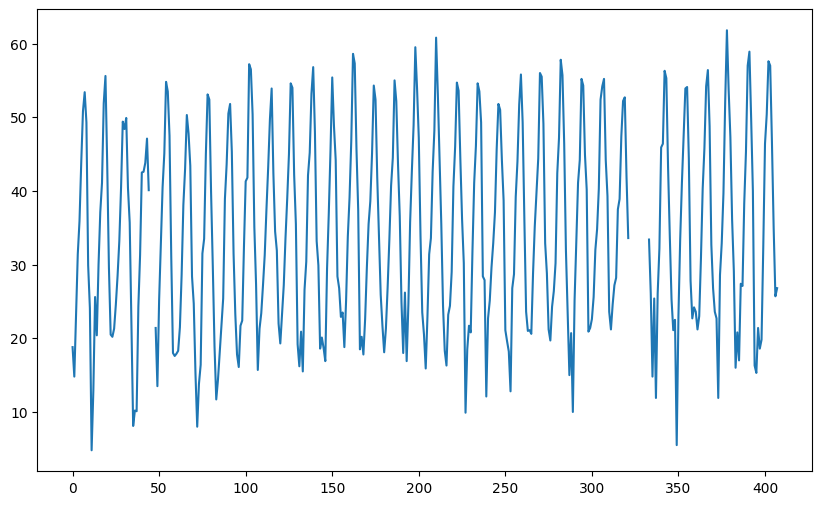

In [31]:
df.columns = ['date','name','id','swe','dswe','sd','dsd','air_temp_avg','air_temp_max','air_temp_min','srad_avg','wind_speed_avg']
fig,ax=plt.subplots(figsize = (10,6))
ax.plot(df.air_temp_avg)

In [8]:
import requests
import pandas as pd
from io import StringIO

def get_snotel_data(state = 'MT', start_date = '2020-01-01', end_date = '2024-01-14'):
    url = f"https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultipleStationReport/daily/start_of_period/state=%22{state}%22%20AND%20network=%22SNTLT%22,%22SNTL%22%20AND%20element=%22SNWD%22%20AND%20outServiceDate=%222100-01-01%22%7Cname/{start_date},{end_date}/name,stationId,WTEQ::value,SNWD::value,elevation,latitude,longitude?fitToScreen=false"
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text

    num_comment_lines = sum(1 for line in content.split('\n') if line.startswith('#'))
    num_comment_lines
    df = pd.read_csv(StringIO(content), skiprows=num_comment_lines)
    return df

df = get_snotel_data()


In [9]:
df.head()

,Date,Station Name,Station Id,Snow Water Equivalent (in) Start of Day Values,Snow Depth (in) Start of Day Values,Elevation (ft),Latitude,Longitude
0,2020-01-01,Albro Lake,916,7.7,32.0,8300,45.59723,-111.95902
1,2020-01-02,Albro Lake,916,7.9,34.0,8300,45.59723,-111.95902
2,2020-01-03,Albro Lake,916,7.9,33.0,8300,45.59723,-111.95902
3,2020-01-04,Albro Lake,916,7.9,33.0,8300,45.59723,-111.95902
4,2020-01-05,Albro Lake,916,8.0,32.0,8300,45.59723,-111.95902


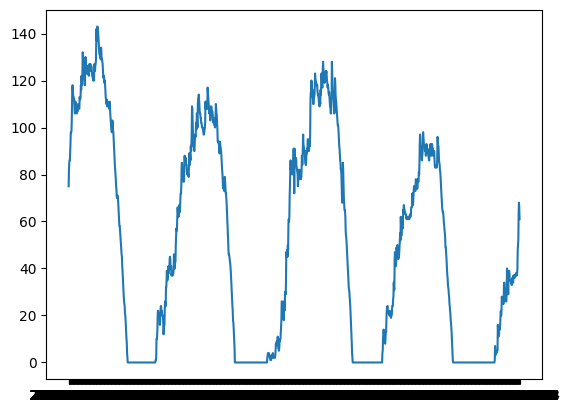

In [14]:
df.columns = ['date','station_name','station_id','swe','sd','elevation_ft','lat','long']
ft = df[df.station_name.apply(lambda x:'flattop' in x.lower())]
fig,ax=plt.subplots()
ax.plot(ft.date,ft.sd)

In [13]:
ft['date'] = ft['date'].apply(lambda x : pd.to_datetime(x))

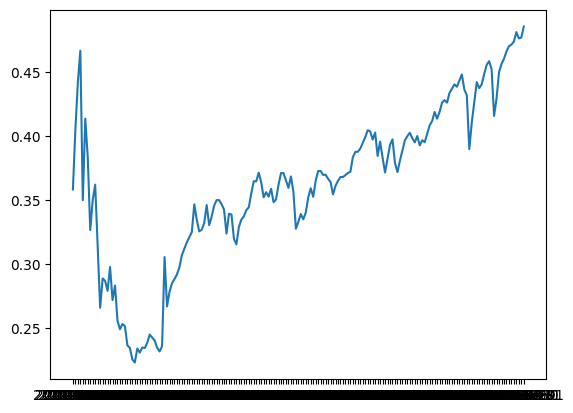

In [21]:
subdf = ft[ft.date.apply(lambda x : x >= '2021-12-01' and x<='2022-06-01')]
fig,ax=plt.subplots()
subdf['snow_density'] = subdf['swe']/subdf['sd']
ax.plot(subdf.date,subdf.snow_density)